In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_csv('ma_lga_12345.csv', parse_dates=["saledate"], dayfirst=True)
dataset = dataset.set_index("saledate").to_period("M").reset_index()
dataset.head()

,saledate,MA,type,bedrooms
0,2007-09,441854,house,2
1,2007-12,441854,house,2
2,2008-03,441854,house,2
3,2008-06,441854,house,2
4,2008-09,451583,house,2


In [3]:
date_grp = dataset.groupby("saledate")

max_len = 0
dates = []
for i in date_grp.groups.values():
    if len(i) >= max_len:
        max_len = len(i)
        
for i, j in date_grp.groups.items():
    if len(j) < max_len:
        dates.append(i)
        
dates

[Period('2007-03', 'M'), Period('2007-06', 'M'), Period('2007-09', 'M')]

In [4]:
updated_dataset = dataset.copy()
update_dataset_filt = dataset["saledate"]>dates[-1]
updated_dataset = updated_dataset[update_dataset_filt]
    
updated_dataset = updated_dataset.sort_values(by="saledate")
dataset = updated_dataset

dataset.shape

(336, 4)

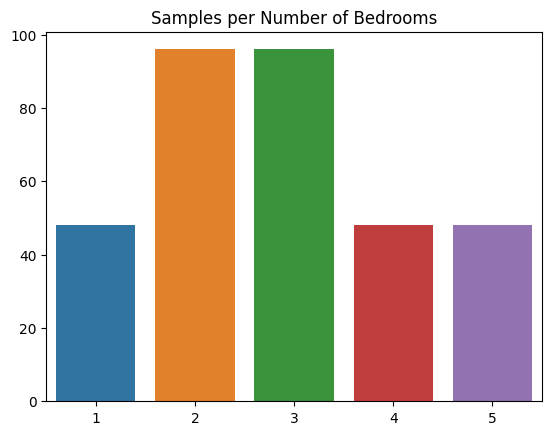

In [5]:
bed_grp = dataset.groupby("bedrooms")
x = list(bed_grp.groups.keys())
y = [len(num_data) for num_data in bed_grp.groups.values()]
bed_data = sns.barplot(x=x, y=y)
bed_data.set(title="Samples per Number of Bedrooms")
bed_data.figure.savefig("Samples per Number of Bedrooms")

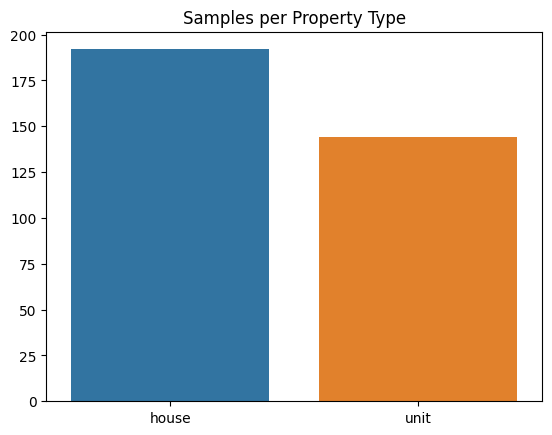

In [6]:
type_grp = dataset.groupby("type")
x = list(type_grp.groups.keys())
y = [len(num_data) for num_data in type_grp.groups.values()]
type_data = sns.barplot(x=x, y=y)
type_data.set(title="Samples per Property Type")
type_data.figure.savefig("Samples per Property Type")

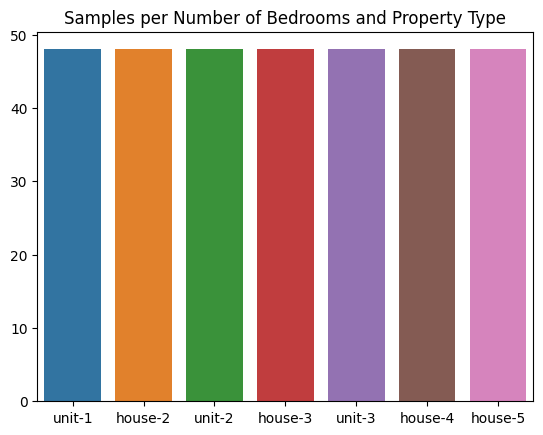

In [7]:
bed_type_grp = dataset.groupby(["bedrooms", "type"])
x = [f"{feat[1]}-{feat[0]}" for feat in list(bed_type_grp.groups.keys())]
y = [len(num_data) for num_data in bed_type_grp.groups.values()]
bed_type_data = sns.barplot(x=x, y=y)
bed_type_data.set(title="Samples per Number of Bedrooms and Property Type")
bed_type_data.figure.savefig("Samples per Number of Bedrooms and Property Type")

In [8]:
updated_date_grp = dataset.groupby("saledate")
time_dict = {}

counter = 0
for i in updated_date_grp.groups.keys():
    if i not in time_dict:
        time_dict[i] = counter
        counter += 1

In [9]:
time = np.ones((dataset.shape[0], 1))
counter = 0
for date in dataset["saledate"]:
    time[counter] = time_dict[date]
    counter += 1

dataset_with_time = dataset.copy()
dataset_with_time = dataset_with_time.assign(time=time)
dataset = dataset_with_time

In [10]:
from sklearn.preprocessing import LabelEncoder

dataset_2 = dataset.copy()
enc = LabelEncoder()
dataset_2["type"] = enc.fit_transform(dataset_2["type"])
dataset_2.shape

(336, 5)

In [11]:
dataset = dataset_2
dataset.set_index("saledate")

,MA,type,bedrooms,time
saledate,,,,
2007-12,441854,0,2,0.0
2007-12,326076,1,1,0.0
2007-12,518911,1,3,0.0
2007-12,421291,0,3,0.0
2007-12,548969,0,4,0.0
...,...,...,...,...
2019-09,791446,0,4,47.0
2019-09,335449,1,1,47.0
2019-09,631875,0,3,47.0


In [12]:
dataset.corr(numeric_only=True)

,MA,type,bedrooms,time
MA,1.000000,-5.560312e-01,9.282606e-01,2.583556e-01
type,-0.556031,1.000000e+00,-5.960396e-01,-1.812216e-16
bedrooms,0.928261,-5.960396e-01,1.000000e+00,-1.392707e-16
time,0.258356,-1.812216e-16,-1.392707e-16,1.000000e+00


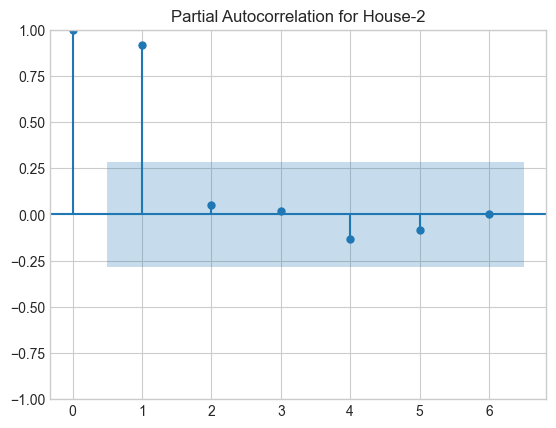

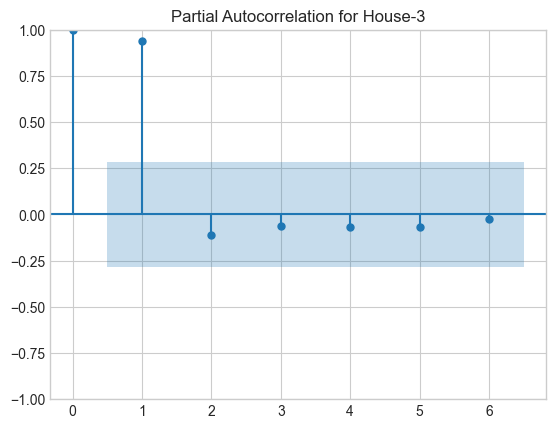

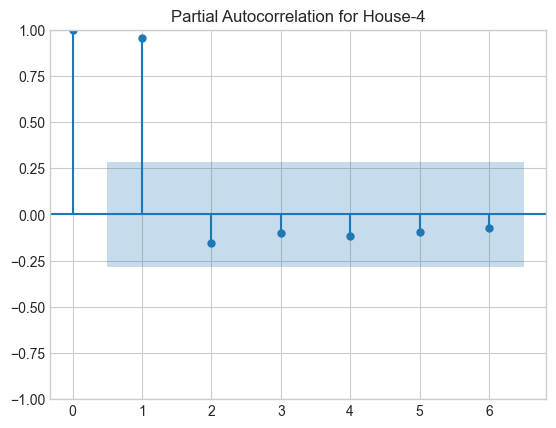

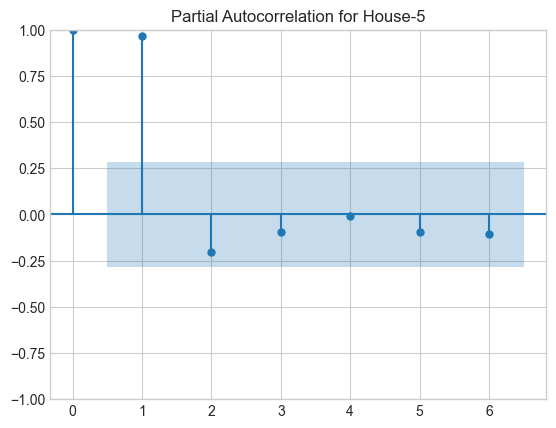

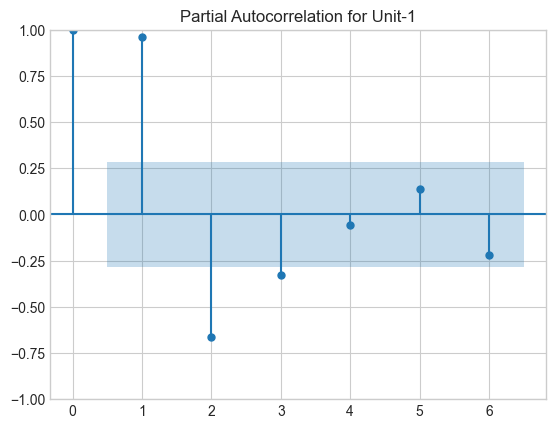

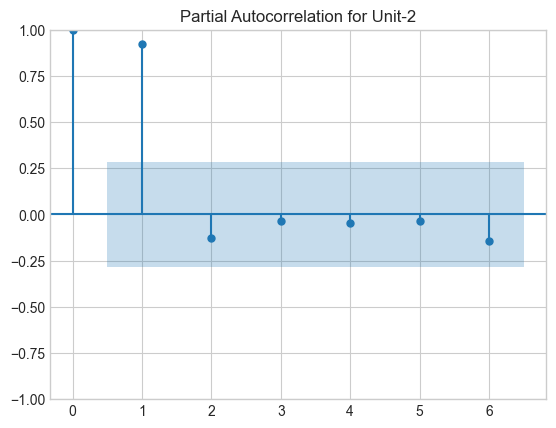

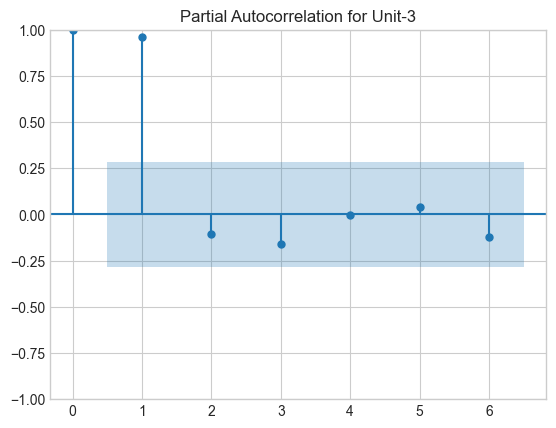

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.style.use('seaborn-v0_8-whitegrid')
# fig, ax = plt.subplots(7, 1, figsize=(6,20))

type_bed_grp = dataset.groupby(["type", "bedrooms"])

for i in type_bed_grp.groups.keys():
    data = type_bed_grp.get_group(i)
    # house_2_data = house_2_data.reset_index()

    home_type = None
    if i[0] == 0:
        home_type = "House"
    else:
        home_type = "Unit"
    
    title = f"{home_type}-{i[1]}"
    ax = plot_pacf(data["MA"].values, lags=6, method="ywm", title=f"Partial Autocorrelation for {title}")
    ax.savefig(title)

In [14]:
new_dataset = dataset.assign(prev_price=np.ones((dataset.shape[0],1)))
new_dataset    

,saledate,MA,type,bedrooms,time,prev_price
1,2007-12,441854,0,2,0.0,1.0
200,2007-12,326076,1,1,0.0,1.0
299,2007-12,518911,1,3,0.0,1.0
52,2007-12,421291,0,3,0.0,1.0
103,2007-12,548969,0,4,0.0,1.0
...,...,...,...,...,...,...
150,2019-09,791446,0,4,47.0,1.0
247,2019-09,335449,1,1,47.0,1.0
99,2019-09,631875,0,3,47.0,1.0
199,2019-09,970268,0,5,47.0,1.0


In [15]:
temp_dataset = new_dataset
type_bed_grp = temp_dataset.groupby(["type", "bedrooms"])


for i in type_bed_grp.groups.keys():
    data = type_bed_grp.get_group(i)
    lags = data["MA"].shift(1).fillna(0)
    temp_dataset.loc[data.index, "prev_price"] = lags

In [16]:
temp_dataset.rename(columns={"MA": "price_1"}, inplace=True)
temp_dataset

,saledate,price_1,type,bedrooms,time,prev_price
1,2007-12,441854,0,2,0.0,0.0
200,2007-12,326076,1,1,0.0,0.0
299,2007-12,518911,1,3,0.0,0.0
52,2007-12,421291,0,3,0.0,0.0
103,2007-12,548969,0,4,0.0,0.0
...,...,...,...,...,...,...
150,2019-09,791446,0,4,47.0,803925.0
247,2019-09,335449,1,1,47.0,336551.0
99,2019-09,631875,0,3,47.0,630814.0
199,2019-09,970268,0,5,47.0,995363.0


In [17]:
dataset = temp_dataset.copy()
dataset.corr(numeric_only=True)

,price_1,type,bedrooms,time,prev_price
price_1,1.000000,-5.560312e-01,9.282606e-01,2.583556e-01,0.924574
type,-0.556031,1.000000e+00,-5.960396e-01,-1.812216e-16,-0.497086
bedrooms,0.928261,-5.960396e-01,1.000000e+00,-1.392707e-16,0.832875
time,0.258356,-1.812216e-16,-1.392707e-16,1.000000e+00,0.330943
prev_price,0.924574,-4.970865e-01,8.328754e-01,3.309426e-01,1.000000


In [18]:
new_dataset = temp_dataset
array_ones = np.ones((new_dataset.shape[0], 1))
new_dataset = new_dataset.assign(price_2=array_ones, price_3=array_ones, price_4=array_ones)
new_dataset.head()

,saledate,price_1,type,bedrooms,time,prev_price,price_2,price_3,price_4
1,2007-12,441854,0,2,0.0,0.0,1.0,1.0,1.0
200,2007-12,326076,1,1,0.0,0.0,1.0,1.0,1.0
299,2007-12,518911,1,3,0.0,0.0,1.0,1.0,1.0
52,2007-12,421291,0,3,0.0,0.0,1.0,1.0,1.0
103,2007-12,548969,0,4,0.0,0.0,1.0,1.0,1.0


In [23]:
temp_dataset = new_dataset.copy()
type_bed_grp = temp_dataset.groupby(["type", "bedrooms"])


for i in type_bed_grp.groups.keys():
    data = type_bed_grp.get_group(i)
    lead2 = data["price_1"].shift(-1)
    lead3 = data["price_1"].shift(-2)
    lead4 = data["price_1"].shift(-3)
    temp_dataset.loc[data.index, "price_2"] = lead2 
    temp_dataset.loc[data.index, "price_3"] = lead3
    temp_dataset.loc[data.index, "price_4"] = lead4

In [24]:
temp_dataset

,saledate,price_1,type,bedrooms,time,prev_price,price_2,price_3,price_4
1,2007-12,441854,0,2,0.0,0.0,441854.0,441854.0,451583.0
200,2007-12,326076,1,1,0.0,0.0,326076.0,326076.0,326076.0
299,2007-12,518911,1,3,0.0,0.0,518911.0,518911.0,518911.0
52,2007-12,421291,0,3,0.0,0.0,416031.0,419628.0,423811.0
103,2007-12,548969,0,4,0.0,0.0,552484.0,559580.0,561852.0
...,...,...,...,...,...,...,...,...,...
150,2019-09,791446,0,4,47.0,803925.0,NaN,NaN,NaN
247,2019-09,335449,1,1,47.0,336551.0,NaN,NaN,NaN
99,2019-09,631875,0,3,47.0,630814.0,NaN,NaN,NaN
199,2019-09,970268,0,5,47.0,995363.0,NaN,NaN,NaN


In [25]:
new_dataset = temp_dataset[temp_dataset["price_4"].notnull()]
dataset = new_dataset.copy()

In [26]:
dataset

,saledate,price_1,type,bedrooms,time,prev_price,price_2,price_3,price_4
1,2007-12,441854,0,2,0.0,0.0,441854.0,441854.0,451583.0
200,2007-12,326076,1,1,0.0,0.0,326076.0,326076.0,326076.0
299,2007-12,518911,1,3,0.0,0.0,518911.0,518911.0,518911.0
52,2007-12,421291,0,3,0.0,0.0,416031.0,419628.0,423811.0
103,2007-12,548969,0,4,0.0,0.0,552484.0,559580.0,561852.0
...,...,...,...,...,...,...,...,...,...
294,2018-12,426936,1,2,44.0,426970.0,426669.0,425659.0,424412.0
244,2018-12,339350,1,1,44.0,339220.0,337838.0,336551.0,335449.0
96,2018-12,626608,0,3,44.0,624602.0,628423.0,630814.0,631875.0
45,2018-12,506001,0,2,44.0,504318.0,496133.0,500158.0,510712.0


In [27]:
def minMaxScale(dataset, feature, minimum_value=None, range_diff=None):
    if range_diff == None:
        range_diff = dataset.loc[:, feature].max() - dataset.loc[:, feature].min()
    if minimum_value == None:
        minimum_value = dataset.loc[:, feature].min()
    dataset.loc[:, feature] = (dataset.loc[:, feature] - minimum_value)/(range_diff)
    
    return minimum_value, range_diff

def rescale(dataset, feature, minimum_value, range_diff):
    dataset.loc[:, feature] = (dataset.loc[:, feature] * range_diff) + minimum_value

In [28]:
dataset = dataset.set_index("saledate")
dataset.head()

,price_1,type,bedrooms,time,prev_price,price_2,price_3,price_4
saledate,,,,,,,,
2007-12,441854,0,2,0.0,0.0,441854.0,441854.0,451583.0
2007-12,326076,1,1,0.0,0.0,326076.0,326076.0,326076.0
2007-12,518911,1,3,0.0,0.0,518911.0,518911.0,518911.0
2007-12,421291,0,3,0.0,0.0,416031.0,419628.0,423811.0
2007-12,548969,0,4,0.0,0.0,552484.0,559580.0,561852.0


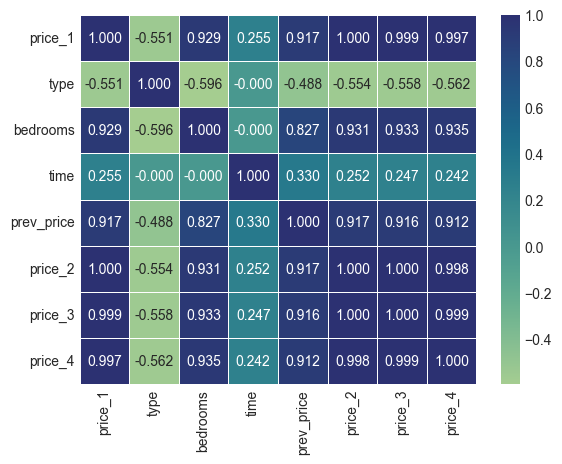

In [29]:
correlations = sns.heatmap(dataset.corr(), annot=True, fmt=".3f", linewidth=.5, cmap="crest")
correlations.figure.savefig("correlations.png")

In [30]:
from sklearn.model_selection import train_test_split

new_dataset = new_dataset.set_index("saledate")
idx_train, idx_test= train_test_split(new_dataset, test_size=0.3, shuffle=False)
idx_train

,price_1,type,bedrooms,time,prev_price,price_2,price_3,price_4
saledate,,,,,,,,
2007-12,441854,0,2,0.0,0.0,441854.0,441854.0,451583.0
2007-12,326076,1,1,0.0,0.0,326076.0,326076.0,326076.0
2007-12,518911,1,3,0.0,0.0,518911.0,518911.0,518911.0
2007-12,421291,0,3,0.0,0.0,416031.0,419628.0,423811.0
2007-12,548969,0,4,0.0,0.0,552484.0,559580.0,561852.0
...,...,...,...,...,...,...,...,...
2015-06,534927,0,3,30.0,528926.0,542051.0,549278.0,556586.0
2015-06,477238,0,2,30.0,478398.0,477330.0,479010.0,482440.0
2015-09,477330,0,2,31.0,477238.0,479010.0,482440.0,486436.0


In [31]:
in_features = ["type", "bedrooms", "time", "prev_price"]
out_features = ["price_1", "price_2", "price_3", "price_4"]
X_train, y_train = idx_train.loc[:, in_features], idx_train.loc[:, out_features] 
X_test, y_test = idx_test.loc[:, in_features], idx_test.loc[:, out_features] 
X_test.head()

,type,bedrooms,time,prev_price
saledate,,,,
2015-09,1,2,31.0,432730.0
2015-09,0,4,31.0,694800.0
2015-09,0,5,31.0,880625.0
2015-09,1,1,31.0,332703.0
2015-12,0,4,32.0,706711.0


In [32]:
X_1_train = X_train["time"].to_numpy().reshape(-1, 1)
X_2_train = X_train[["type", "bedrooms", "prev_price"]]
y_1_train = y_train["price_1"].to_numpy().reshape(-1, 1)

X_1_test = X_test["time"].to_numpy().reshape(-1, 1)
X_2_test = X_test[["type", "bedrooms", "prev_price"]]

train_acc = {}
test_acc = {}
train_r2 = {}
test_r2 = {}
train_median_acc = {}
test_median_acc = {}
train_variance_score = {}
test_variance_score = {}

In [33]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(X_1_train, y_1_train)

LinearRegression()

In [34]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor

tree = MultiOutputRegressor(DecisionTreeRegressor(max_depth=8))

outputs = np.array([lin_reg.predict(X_1_train), lin_reg.predict(X_1_train+1), lin_reg.predict(X_1_train+2), lin_reg.predict(X_1_train+3)])
outputs = outputs.squeeze().transpose()
y_updated = y_train.to_numpy() - outputs
tree.fit(X_2_train, y_updated)

MultiOutputRegressor(estimator=DecisionTreeRegressor(max_depth=8))

In [35]:
tree_preds = tree.predict(X_2_train)
lin_out = np.array([lin_reg.predict(X_1_train), lin_reg.predict(X_1_train+1), lin_reg.predict(X_1_train+2), lin_reg.predict(X_1_train+3)])
lin_preds = lin_out.squeeze().transpose()

preds = np.zeros((len(tree_preds), 4))
for i in range(len(tree_preds)):
    preds[i] = tree_preds[i] + lin_preds[i]

In [36]:
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error, mean_poisson_deviance

lin_tree_train_acc = mean_squared_error(y_train, preds, squared=False)
train_acc["lin_tree_unscaled"] = lin_tree_train_acc
train_r2["lin_tree_unscaled"] = r2_score(y_train, preds)
train_median_acc["lin_tree_unscaled"] = median_absolute_error(y_train, preds)
lin_tree_train_acc

4225.881000696078

In [37]:
tree_preds = tree.predict(X_2_test)
lin_out = np.array([lin_reg.predict(X_1_test), lin_reg.predict(X_1_test+1), lin_reg.predict(X_1_test+2), lin_reg.predict(X_1_test+3)])
lin_preds = lin_out.squeeze().transpose()

preds = np.zeros((len(tree_preds), 4))
for i in range(len(tree_preds)):
    preds[i] = tree_preds[i] + lin_preds[i]
    
lin_tree_test_acc = mean_squared_error(y_test, preds, squared=False)
test_acc["lin_tree_unscaled"] = lin_tree_test_acc
test_r2["lin_tree_unscaled"] = r2_score(y_test, preds)
test_median_acc["lin_tree_unscaled"] = median_absolute_error(y_test, preds)
lin_tree_test_acc

48692.0757092467

In [38]:
from sklearn.svm import SVR

svr = SVR(kernel="linear")

y_1_train = y_train["price_1"].to_numpy()

svr.fit(X_1_train, y_1_train)

SVR(kernel='linear')

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import RegressorChain

forest = RegressorChain(RandomForestRegressor())

outputs = np.array([svr.predict(X_1_train), svr.predict(X_1_train+1), svr.predict(X_1_train+2), svr.predict(X_1_train+3)])
outputs = outputs.squeeze().transpose()
y_updated = y_train.to_numpy() - outputs
forest.fit(X_2_train, y_updated)

RegressorChain(base_estimator=RandomForestRegressor())

In [40]:
forest_preds = forest.predict(X_2_train)
svr_out = np.array([svr.predict(X_1_train), svr.predict(X_1_train+1), svr.predict(X_1_train+2), svr.predict(X_1_train+3)])
svr_preds = svr_out.squeeze().transpose()

preds = np.zeros((len(forest_preds), 4))
for i in range(len(forest_preds)):
    preds[i] = forest_preds[i] + svr_preds[i]

In [41]:
svr_forest_train_acc = mean_squared_error(y_train, preds, squared=False)
train_acc["svr_forest_unscaled"] = svr_forest_train_acc
train_r2["svr_forest_unscaled"] = r2_score(y_train, preds)
train_median_acc["svr_forest_unscaled"] = median_absolute_error(y_train, preds)

svr_forest_train_acc

8911.133560341077

In [42]:
forest_preds = forest.predict(X_2_test)
svr_out = np.array([svr.predict(X_1_test), svr.predict(X_1_test+1), svr.predict(X_1_test+2), svr.predict(X_1_test+3)])
svr_preds = svr_out.squeeze().transpose()

preds = np.zeros((len(forest_preds), 4))
for i in range(len(forest_preds)):
    preds[i] = forest_preds[i] + svr_preds[i]
    
svr_forest_test_acc = mean_squared_error(y_test, preds, squared=False)
test_acc["svr_forest_unscaled"] = svr_forest_test_acc
test_r2["svr_forest_unscaled"] = r2_score(y_test, preds)
test_median_acc["svr_forest_unscaled"] = median_absolute_error(y_test, preds)

svr_forest_test_acc

41712.49884646208

In [43]:
from sklearn.svm import SVR

svr_2 = SVR(kernel="rbf")

svr_2.fit(X_1_train, y_1_train)

SVR()

In [44]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import RegressorChain

gboost = RegressorChain(GradientBoostingRegressor(n_estimators=150))

outputs = np.array([svr_2.predict(X_1_train), svr_2.predict(X_1_train+1), svr_2.predict(X_1_train+2), svr_2.predict(X_1_train+3)])
outputs = outputs.squeeze().transpose()
y_updated = y_train.to_numpy() - outputs
gboost.fit(X_2_train, y_updated)

RegressorChain(base_estimator=GradientBoostingRegressor(n_estimators=150))

In [45]:
gboost_preds = gboost.predict(X_2_train)
svr_out = np.array([svr_2.predict(X_1_train), svr_2.predict(X_1_train+1), svr_2.predict(X_1_train+2), svr_2.predict(X_1_train+3)])
svr_preds = svr_out.squeeze().transpose()

preds = np.zeros((len(gboost_preds), 4))
for i in range(len(gboost_preds)):
    preds[i] = gboost_preds[i] + svr_preds[i]

In [46]:
svr_gboost_train_acc = mean_squared_error(y_train, preds, squared=False)
train_acc["svr_gboost_unscaled"] = svr_gboost_train_acc
train_r2["svr_gboost_unscaled"] = r2_score(y_train, preds)
train_median_acc["svr_gboost_unscaled"] = median_absolute_error(y_train, preds)

svr_gboost_train_acc

5885.434000018999

In [47]:
gboost_preds = gboost.predict(X_2_test)
svr_out = np.array([svr_2.predict(X_1_test), svr_2.predict(X_1_test+1), svr_2.predict(X_1_test+2), svr_2.predict(X_1_test+3)])
svr_preds = svr_out.squeeze().transpose()

preds = np.zeros((len(gboost_preds), 4))
for i in range(len(gboost_preds)):
    preds[i] = gboost_preds[i] + svr_preds[i]
    
svr_gboost_test_acc = mean_squared_error(y_test, preds, squared=False)
test_acc["svr_gboost_unscaled"] = svr_gboost_test_acc
test_r2["svr_gboost_unscaled"] = r2_score(y_test, preds)
test_median_acc["svr_gboost_unscaled"] = median_absolute_error(y_test, preds)

svr_gboost_test_acc

41171.235160253986

In [48]:
min_value, range_diff = minMaxScale(new_dataset, "price_1")
rescale(new_dataset, "price_1", min_value, range_diff)
minMaxScale(new_dataset, "prev_price", min_value, range_diff)

(316751, 701001)

In [49]:
idx_train, idx_test= train_test_split(new_dataset, test_size=0.3, shuffle=False)
idx_train

,price_1,type,bedrooms,time,prev_price,price_2,price_3,price_4
saledate,,,,,,,,
2007-12,441854.0,0,2,0.0,-0.451855,441854.0,441854.0,451583.0
2007-12,326076.0,1,1,0.0,-0.451855,326076.0,326076.0,326076.0
2007-12,518911.0,1,3,0.0,-0.451855,518911.0,518911.0,518911.0
2007-12,421291.0,0,3,0.0,-0.451855,416031.0,419628.0,423811.0
2007-12,548969.0,0,4,0.0,-0.451855,552484.0,559580.0,561852.0
...,...,...,...,...,...,...,...,...
2015-06,534927.0,0,3,30.0,0.302674,542051.0,549278.0,556586.0
2015-06,477238.0,0,2,30.0,0.230595,477330.0,479010.0,482440.0
2015-09,477330.0,0,2,31.0,0.228940,479010.0,482440.0,486436.0


In [50]:
in_features = ["type", "bedrooms", "time", "prev_price"]
out_features = ["price_1", "price_2", "price_3", "price_4"]
X_train, y_train = idx_train.loc[:, in_features], idx_train.loc[:, out_features] 
X_test, y_test = idx_test.loc[:, in_features], idx_test.loc[:, out_features] 
X_test.head()

,type,bedrooms,time,prev_price
saledate,,,,
2015-09,1,2,31.0,0.165448
2015-09,0,4,31.0,0.539299
2015-09,0,5,31.0,0.804384
2015-09,1,1,31.0,0.022756
2015-12,0,4,32.0,0.556290


In [51]:
X_1_train = X_train["time"].to_numpy().reshape(-1, 1)
X_2_train = X_train[["type", "bedrooms", "prev_price"]]
y_1_train = y_train["price_1"].to_numpy().reshape(-1, 1)

X_1_test = X_test["time"].to_numpy().reshape(-1, 1)
X_2_test = X_test[["type", "bedrooms", "prev_price"]]
X_2_train

,type,bedrooms,prev_price
saledate,,,
2007-12,0,2,-0.451855
2007-12,1,1,-0.451855
2007-12,1,3,-0.451855
2007-12,0,3,-0.451855
2007-12,0,4,-0.451855
...,...,...,...
2015-06,0,3,0.302674
2015-06,0,2,0.230595
2015-09,0,2,0.228940


In [52]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(X_1_train, y_1_train)

LinearRegression()

In [53]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor

tree = MultiOutputRegressor(DecisionTreeRegressor(max_depth=8))

outputs = np.array([lin_reg.predict(X_1_train), lin_reg.predict(X_1_train+1), lin_reg.predict(X_1_train+2), lin_reg.predict(X_1_train+3)])
outputs = outputs.squeeze().transpose()
y_updated = y_train.to_numpy() - outputs
tree.fit(X_2_train, y_updated)

MultiOutputRegressor(estimator=DecisionTreeRegressor(max_depth=8))

In [54]:
tree_preds = tree.predict(X_2_train)
lin_out = np.array([lin_reg.predict(X_1_train), lin_reg.predict(X_1_train+1), lin_reg.predict(X_1_train+2), lin_reg.predict(X_1_train+3)])
lin_preds = lin_out.squeeze().transpose()

preds = np.zeros((len(tree_preds), 4))
for i in range(len(tree_preds)):
    preds[i] = tree_preds[i] + lin_preds[i]

In [55]:
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error

lin_tree_train_acc = mean_squared_error(y_train, preds, squared=False)
train_acc["lin_tree_scaled"] = lin_tree_train_acc
train_r2["lin_tree_scaled"] = r2_score(y_train, preds)
train_median_acc["lin_tree_scaled"] = median_absolute_error(y_train, preds)
lin_tree_train_acc

4225.881000696078

In [56]:
tree_preds = tree.predict(X_2_test)
lin_out = np.array([lin_reg.predict(X_1_test), lin_reg.predict(X_1_test+1), lin_reg.predict(X_1_test+2), lin_reg.predict(X_1_test+3)])
lin_preds = lin_out.squeeze().transpose()

preds = np.zeros((len(tree_preds), 4))
for i in range(len(tree_preds)):
    preds[i] = tree_preds[i] + lin_preds[i]
    
lin_tree_test_acc = mean_squared_error(y_test, preds, squared=False)
test_acc["lin_tree_scaled"] = lin_tree_test_acc
test_r2["lin_tree_scaled"] = r2_score(y_test, preds)
test_median_acc["lin_tree_scaled"] = median_absolute_error(y_test, preds)
lin_tree_test_acc

48692.0757092467

In [57]:
from sklearn.svm import SVR

svr = SVR(kernel="linear")

y_1_train = y_train["price_1"].to_numpy()

svr.fit(X_1_train, y_1_train)

SVR(kernel='linear')

In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import RegressorChain

forest = RegressorChain(RandomForestRegressor())

outputs = np.array([svr.predict(X_1_train), svr.predict(X_1_train+1), svr.predict(X_1_train+2), svr.predict(X_1_train+3)])
outputs = outputs.squeeze().transpose()
y_updated = y_train.to_numpy() - outputs
forest.fit(X_2_train, y_updated)

RegressorChain(base_estimator=RandomForestRegressor())

In [59]:
forest_preds = forest.predict(X_2_train)
svr_out = np.array([svr.predict(X_1_train), svr.predict(X_1_train+1), svr.predict(X_1_train+2), svr.predict(X_1_train+3)])
svr_preds = svr_out.squeeze().transpose()

preds = np.zeros((len(forest_preds), 4))
for i in range(len(forest_preds)):
    preds[i] = forest_preds[i] + svr_preds[i]

In [60]:
svr_forest_train_acc = mean_squared_error(y_train, preds, squared=False)
train_acc["svr_forest_scaled"] = svr_forest_train_acc
train_r2["svr_forest_scaled"] = r2_score(y_train, preds)
train_median_acc["svr_forest_scaled"] = median_absolute_error(y_train, preds)

svr_forest_train_acc

8956.87378700346

In [61]:
forest_preds = forest.predict(X_2_test)
svr_out = np.array([svr.predict(X_1_test), svr.predict(X_1_test+1), svr.predict(X_1_test+2), svr.predict(X_1_test+3)])
svr_preds = svr_out.squeeze().transpose()

preds = np.zeros((len(forest_preds), 4))
for i in range(len(forest_preds)):
    preds[i] = forest_preds[i] + svr_preds[i]
    
svr_forest_test_acc = mean_squared_error(y_test, preds, squared=False)
test_acc["svr_forest_scaled"] = svr_forest_test_acc
test_r2["svr_forest_scaled"] = r2_score(y_test, preds)
test_median_acc["svr_forest_scaled"] = median_absolute_error(y_test, preds)

svr_forest_test_acc

43027.77884482553

In [62]:
from sklearn.svm import SVR

svr_2 = SVR(kernel="rbf")

svr_2.fit(X_1_train, y_1_train)

SVR()

In [63]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import RegressorChain

gboost = RegressorChain(GradientBoostingRegressor(n_estimators=150))

outputs = np.array([svr_2.predict(X_1_train), svr_2.predict(X_1_train+1), svr_2.predict(X_1_train+2), svr_2.predict(X_1_train+3)])
outputs = outputs.squeeze().transpose()
y_updated = y_train.to_numpy() - outputs
gboost.fit(X_2_train, y_updated)

RegressorChain(base_estimator=GradientBoostingRegressor(n_estimators=150))

In [64]:
gboost_preds = gboost.predict(X_2_train)
svr_out = np.array([svr_2.predict(X_1_train), svr_2.predict(X_1_train+1), svr_2.predict(X_1_train+2), svr_2.predict(X_1_train+3)])
svr_preds = svr_out.squeeze().transpose()

preds = np.zeros((len(gboost_preds), 4))
for i in range(len(gboost_preds)):
    preds[i] = gboost_preds[i] + svr_preds[i]

In [65]:
svr_gboost_train_acc = mean_squared_error(y_train, preds, squared=False)
train_acc["svr_gboost_scaled"] = svr_gboost_train_acc
train_r2["svr_gboost_scaled"] = r2_score(y_train, preds)
train_median_acc["svr_gboost_scaled"] = median_absolute_error(y_train, preds)

svr_gboost_train_acc

5944.622134144667

In [66]:
gboost_preds = gboost.predict(X_2_test)
svr_out = np.array([svr_2.predict(X_1_test), svr_2.predict(X_1_test+1), svr_2.predict(X_1_test+2), svr_2.predict(X_1_test+3)])
svr_preds = svr_out.squeeze().transpose()

preds = np.zeros((len(gboost_preds), 4))
for i in range(len(gboost_preds)):
    preds[i] = gboost_preds[i] + svr_preds[i]
    
svr_gboost_test_acc = mean_squared_error(y_test, preds, squared=False)
test_acc["svr_gboost_scaled"] = svr_gboost_test_acc
test_r2["svr_gboost_scaled"] = r2_score(y_test, preds)
test_median_acc["svr_gboost_scaled"] = median_absolute_error(y_test, preds)

svr_gboost_test_acc

41963.37479540549

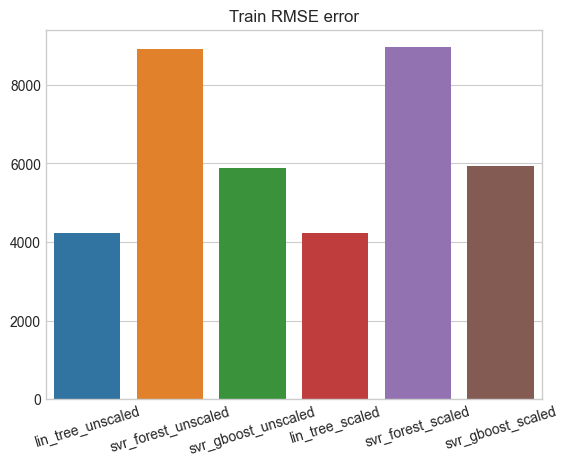

In [75]:
train_rmse_data = pd.DataFrame([train_acc])
train_rmse_bar_plot = sns.barplot(train_rmse_data)
train_rmse_bar_plot.set_xticklabels(train_rmse_bar_plot.get_xticklabels(), rotation=17)
train_rmse_bar_plot.set(title="Train RMSE error")
train_rmse_bar_plot.figure.savefig("Train RMSE error")

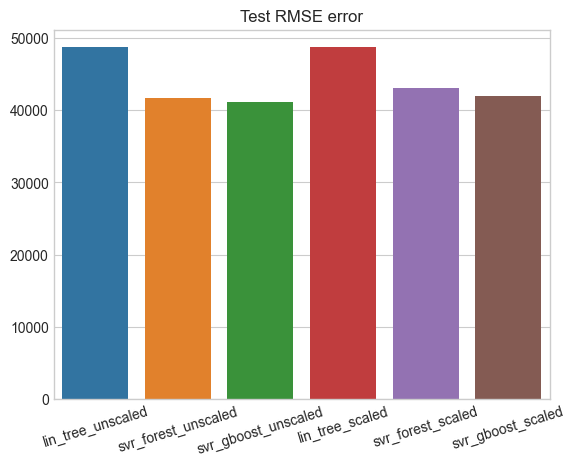

In [81]:
test_rmse_data = pd.DataFrame([test_acc])
test_rmse_bar_plot = sns.barplot(test_rmse_data)
test_rmse_bar_plot.set_xticklabels(test_rmse_bar_plot.get_xticklabels(), rotation=17)
test_rmse_bar_plot.set(title="Test RMSE error")
test_rmse_bar_plot.figure.savefig("Test RMSE error")

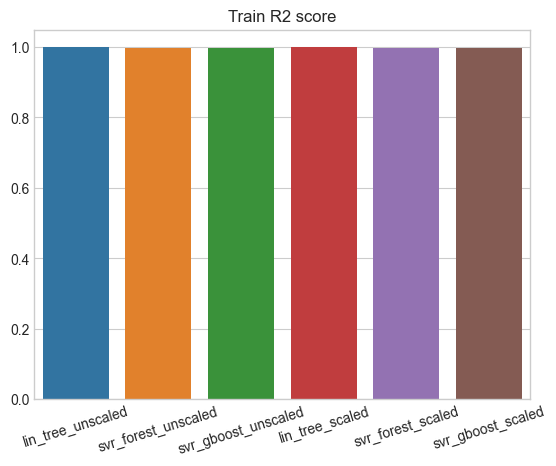

In [82]:
train_r2_data = pd.DataFrame([train_r2])
train_r2_bar_plot = sns.barplot(train_r2_data)
train_r2_bar_plot.set_xticklabels(train_r2_bar_plot.get_xticklabels(), rotation=17)
train_r2_bar_plot.set(title="Train R2 score")
train_r2_bar_plot.figure.savefig("Train R2 error")

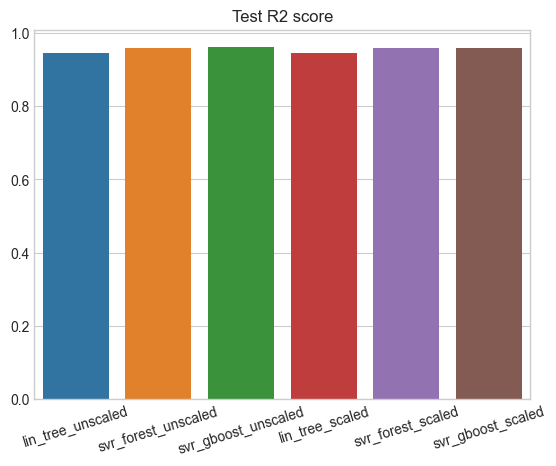

In [83]:
test_r2_data = pd.DataFrame([test_r2])
test_r2_bar_plot = sns.barplot(test_r2_data)
test_r2_bar_plot.set_xticklabels(test_r2_bar_plot.get_xticklabels(), rotation=17)
test_r2_bar_plot.set(title="Test R2 score")
test_r2_bar_plot.figure.savefig("Test R2 error")

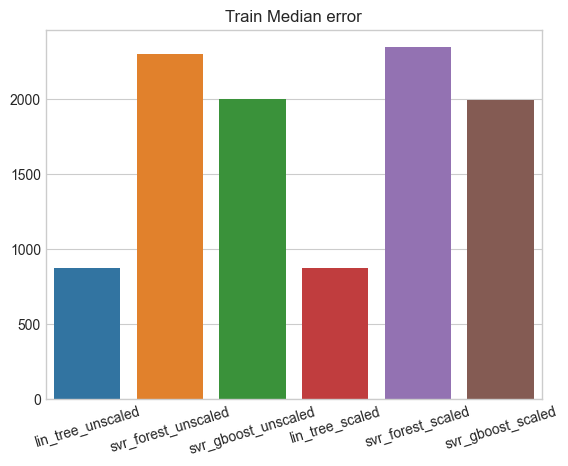

In [79]:
train_median_data = pd.DataFrame([train_median_acc])
train_median_bar_plot = sns.barplot(train_median_data)
train_median_bar_plot.set_xticklabels(train_median_bar_plot.get_xticklabels(), rotation=17)
train_median_bar_plot.set(title="Train Median error")
train_median_bar_plot.figure.savefig("Train Median error")

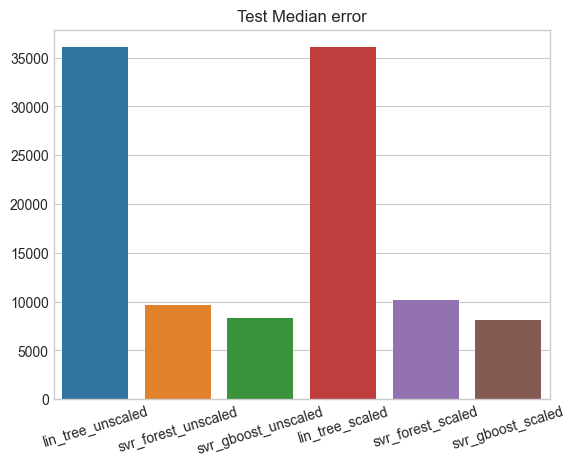

In [80]:
test_median_data = pd.DataFrame([test_median_acc])
test_median_bar_plot = sns.barplot(test_median_data)
test_median_bar_plot.set_xticklabels(test_median_bar_plot.get_xticklabels(), rotation=17)
test_median_bar_plot.set(title="Test Median error")
test_median_bar_plot.figure.savefig("Test Median error")

,lin_tree_unscaled,svr_forest_unscaled,svr_gboost_unscaled,lin_tree_scaled,svr_forest_scaled,svr_gboost_scaled
0,36064.115074,9576.698312,8567.291659,36064.115074,10023.171,8353.825698
